### Upwelled tracer

In this notebook we compare Tr mass and HCW in all 4 runs and for all tracers. Then we find the tracer and water upwelling flux ($\Phi$, $\Phi_{Tr}$) and compare it to scaling estimates from Ramos-Musalem and Allen 2019 and Howatt and Allen 2013, respectively.

* HCW all calculated with lin tracer, but shouldn't it be the same for all tracers ideally? Ideally, I think so, but some profiles will be more diffusive (if they concave) and thus, will find less upwelled water. By sticking to the linear profile we guaratee that we are counting tracer mass only on the same pool for water.

* TrMass calculated using lin tracer to find cells with upwelled water and concetration from the tracer we are studying.

CAREFUL: UNITS ARE ALL WEIRD FOR OXY, DIC, ALK!!

In [1]:
import cmocean as cmo
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

import matplotlib.gridspec as gspec

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [4]:
def getProfile(ptracers_file, mask, trac, xind, yind, zslice, tt):
    
    with Dataset(ptracers_file, 'r') as nbl:
        
        tr = np.ma.masked_array(nbl.variables[trac][tt,zslice,yind,xind], mask = mask[zslice,yind,xind])
       
    return (tr)

In [5]:
ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc'

ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'

ptr_fileBNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/ptracersGlob.nc'
grid_fileBNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/gridGlob.nc'

ptr_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/ptracersGlob.nc'
grid_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/gridGlob.nc'

In [6]:
nz = 104
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

with Dataset(ptr_fileA, 'r') as nbl:
    time = nbl.variables['T'][:]
    
with Dataset(grid_fileB, 'r') as nbl:
    ZB = nbl.variables['RC'][:]
    YB = nbl.variables['Y'][:]
    XB = nbl.variables['X'][:]
    hFacB = nbl.variables['HFacC'][:]
    DepthB = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacB, 0)
    maskCB = np.ma.getmask(hfac)
    rAB = nbl.variables['rA'][:]
    
with Dataset(grid_fileA, 'r') as nbl:
    ZA = nbl.variables['RC'][:]
    YA = nbl.variables['Y'][:]
    XA = nbl.variables['X'][:]
    hFacA = nbl.variables['HFacC'][:]
    DepthA = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacA, 0)
    maskCA = np.ma.getmask(hfac)
    rAA = nbl.variables['rA'][:]
    
with Dataset(grid_fileBNoC, 'r') as nbl:
    hFacBNoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacBNoC, 0)
    maskCBNoC = np.ma.getmask(hfacNoC)
    
with Dataset(grid_fileANoC, 'r') as nbl:
    hFacANoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacANoC, 0)
    maskCANoC = np.ma.getmask(hfacNoC)
   

### 01 - Initial profiles

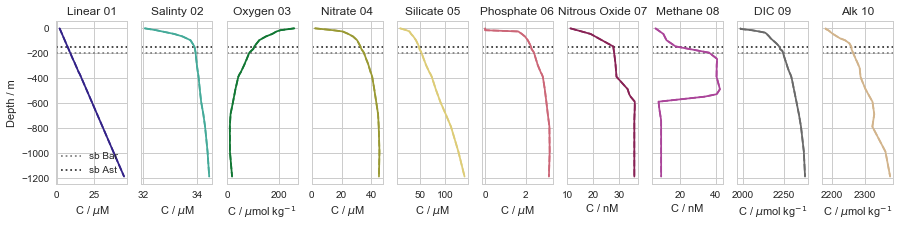

In [7]:
tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']
#colours = ['purple','blue','green','gold','orange','red','orchid','teal']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
fig,ax = plt.subplots(1,len(tracers),figsize=(15,3), sharey = True)
    
for ii, trac, col, lab in zip(range(len(tracers)),tracers , colours, labels):

    ax[ii].axhline(-200, linestyle=':', color='0.5', label='sb Bar')
    ax[ii].axhline(-150, linestyle=':', color='0.2', label='sb Ast')
    
    for pfile, Z, style in zip([ptr_fileB, ptr_fileA],[ZB, ZA],['-', '--']):
        
        with Dataset(pfile, 'r') as nbl:
            tr_profile = nbl.variables[trac][0,:,10,180]

        ax[ii].plot(tr_profile, Z, color=col,linestyle=style)
        ax[ii].set_title(lab)
        
        if (trac == 'Tr07' or trac == 'Tr08'):
            ax[ii].set_xlabel('C / nM')
        elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
            ax[ii].set_xlabel('C / $\mu$mol kg$^{-1}$')
        else:
            ax[ii].set_xlabel(r'C / $\mu$M')

ax[0].set_ylabel('Depth / m')        
ax[0].legend(loc=0)

Initial profiles. Profiles for both runs plotted to check they are actually the same.

#### Vertical tracer gradient

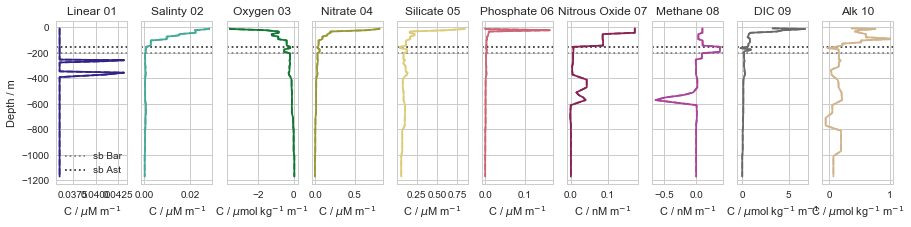

In [8]:
dTr_Ast = np.empty(len(tracers))
dTr_Bar = np.empty(len(tracers))
Tr_Ast = np.empty(len(tracers))
Tr_Bar = np.empty(len(tracers))

fig,ax = plt.subplots(1,len(tracers),figsize=(15,3), sharey = True)
    
for ii, trac, col, lab in zip(range(len(tracers)),tracers , colours, labels):

    ax[ii].axhline(-200, linestyle=':', color='0.5', label='sb Bar')
    ax[ii].axhline(-150, linestyle=':', color='0.2', label='sb Ast')
    
    for pfile, Z, style in zip([ptr_fileB, ptr_fileA],[ZB, ZA],['-', '--']):
        
        with Dataset(pfile, 'r') as nbl:
            tr_profile = nbl.variables[trac][0,:,10,180]
            dTrdz = (tr_profile[2:]-tr_profile[:-2])/(-Z[2:]+Z[:-2])  
            dTr_Ast[ii] = dTrdz[sb_Ast+1]/dTrdz[sb_Ast-1]
            dTr_Bar[ii] = dTrdz[sb_Bar+1]/dTrdz[sb_Bar-1]
            Tr_Ast[ii] = tr_profile[sb_Ast]
            Tr_Bar[ii] = tr_profile[sb_Bar]
            
        ax[ii].plot(dTrdz, Z[1:-1], color=col,linestyle=style)
        ax[ii].set_title(lab)
        
        if (trac == 'Tr07' or trac == 'Tr08'):
            ax[ii].set_xlabel('C / nM m$^{-1}$')
        elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
            ax[ii].set_xlabel('C / $\mu$mol kg$^{-1}$ m$^{-1}$')
        else:
            ax[ii].set_xlabel(r'C / $\mu$M m$^{-1}$')

ax[0].set_ylabel('Depth / m')        
ax[0].legend(loc=0)

Get initial concentration at shelf break

In [9]:
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'

tracers_C = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels_C = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']

sb_conc_A = np.empty(len(labels))
sb_conc_B = np.empty(len(labels))

for ii, trac in zip(range(len(tracers_C)),tracers_C):
    for pfile,sb_array, sb_ind in zip([ptr_fileB, ptr_fileA],[sb_conc_A, sb_conc_B], [sb_Ast, sb_Bar]):
        with Dataset(pfile, 'r') as nbl:
            tr_profile = nbl.variables[trac][0,:,10,180]
            sb_array[ii] = tr_profile[sb_ind]

### 02 - HCW



Canyon runs, using linear tracer

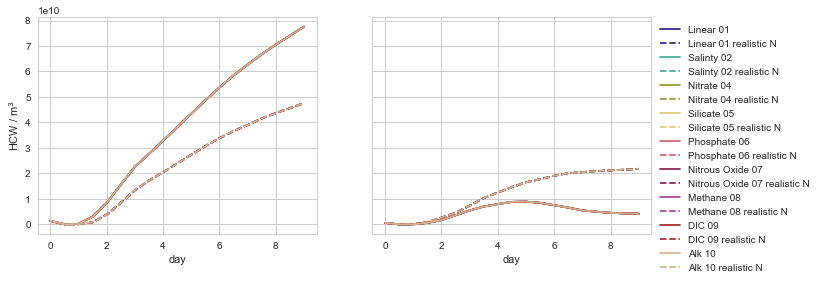

In [10]:
fig, ax = plt.subplots(1,2,figsize=(11,4), sharey=True)

tracers2 = ['Tr01','Tr02','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels2 = ['Linear 01','Salinty 02','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07',
           'Methane 08','DIC 09', 'Alk 10']
colours2 = ['#332288','#44AA99','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'brown', 'tan']

for key, col, lab in zip(tracers2, colours2, labels2):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
    df_Ast = pd.read_csv(f_Ast)
    HCW_Ast = df_Ast['HCW']
    f_Ast3 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_03.csv' %key)
    df_Ast3 = pd.read_csv(f_Ast3)
    HCW_Ast3 = df_Ast3['HCW']
    
    ax[0].plot(np.arange(19)/2, HCW_Ast, color=col, label=lab)
    ax[0].plot(np.arange(19)/2, HCW_Ast3,'--', color=col, label=lab)
    
    f_Bar = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_01.csv' %key)
    df_Bar = pd.read_csv(f_Bar)
    HCW_Bar = df_Bar['HCW']
    f_Bar3 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_03.csv' %key)
    df_Bar3 = pd.read_csv(f_Bar3)
    HCW_Bar3 = df_Bar3['HCW']
   
    ax[1].plot(np.arange(19)/2, HCW_Bar, color=col, label=lab)
    ax[1].plot(np.arange(19)/2, HCW_Bar3,'--', color=col, label=lab+' realistic N')

ax[0].set_ylabel('HCW / m$^3$')
ax[0].set_xlabel('day')
ax[1].set_xlabel('day')

ax[1].legend(bbox_to_anchor=(1,1))

### 03. Upwelled Tracer - Astoria bathymetry

**Canyon runs, Astorias**

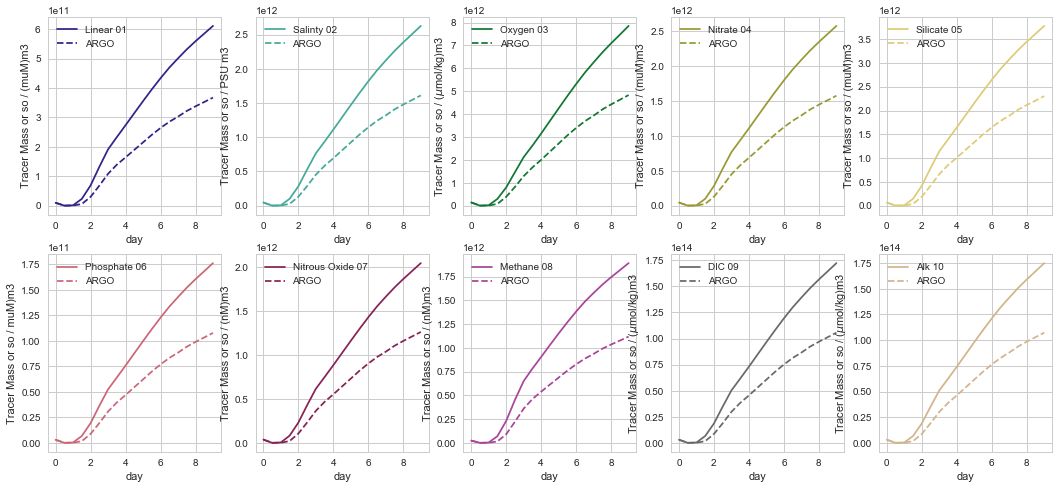

In [11]:
fig, ((ax0,ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8,ax9)) = plt.subplots(2,5,figsize=(18,8))

units = ['(muM)m3','PSU m3','($\mu$mol/kg)m3','(muM)m3','(muM)m3','muM)m3','(nM)m3',
         '(nM)m3','($\mu$mol/kg)m3','($\mu$mol/kg)m3']

axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for key, col, lab, unit,ax in zip(tracers, colours, labels, units, axes):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_03.csv' %key)
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
    
    TrMass_Ast = df_Ast['TrMassHCW']
    TrMass_Argo = df_Argo['TrMassHCW']
    
    ax.plot(np.arange(19)/2, TrMass_Ast, color=col, label=lab)
    ax.plot(np.arange(19)/2, TrMass_Argo,'--', color=col, label='ARGO')
    ax.legend()
    ax.set_ylabel(r'Tracer Mass or so / %s' %unit)
    ax.set_xlabel('day')



**No canyon**

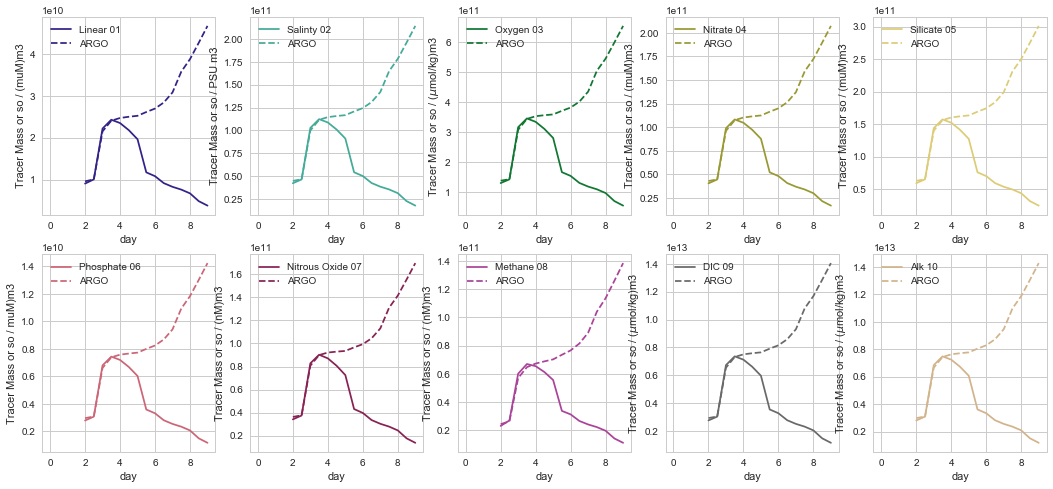

In [12]:
fig, ((ax0,ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8,ax9)) = plt.subplots(2,5,figsize=(18,8))

units = ['(muM)m3','PSU m3','($\mu$mol/kg)m3','(muM)m3','(muM)m3','muM)m3','(nM)m3',
         '(nM)m3','($\mu$mol/kg)m3','($\mu$mol/kg)m3']

axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for key, col, lab, unit,ax in zip(tracers, colours, labels, units, axes):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_02.csv' %key)
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_04.csv' %key)
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
    
    TrMass_Ast = df_Ast['TrMassHCW']
    TrMass_Argo = df_Argo['TrMassHCW']
    
    ax.plot(np.arange(19)/2, TrMass_Ast, color=col, label=lab)
    ax.plot(np.arange(19)/2, TrMass_Argo,'--', color=col, label='ARGO')
    ax.legend()
    ax.set_ylabel(r'Tracer Mass or so / %s' %unit)
    ax.set_xlabel('day')



**Canyon effect** (Can - no Can runs)

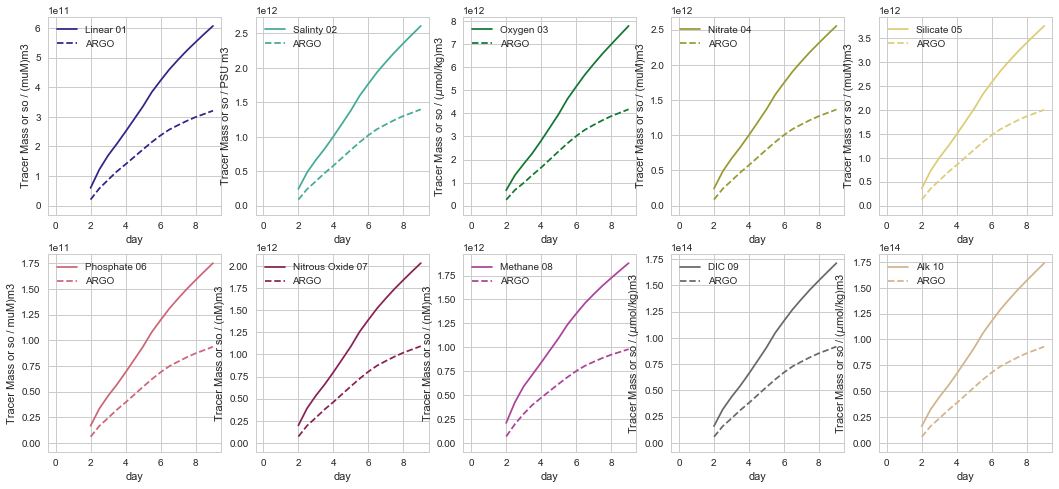

In [13]:
fig, ((ax0,ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8,ax9)) = plt.subplots(2,5,figsize=(18,8))

units = ['(muM)m3','PSU m3','($\mu$mol/kg)m3','(muM)m3','(muM)m3','muM)m3','(nM)m3',
         '(nM)m3','($\mu$mol/kg)m3','($\mu$mol/kg)m3']

axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for key, col, lab, unit,ax in zip(tracers, colours, labels, units, axes):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
    f_AstNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_02.csv' %key)
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_03.csv' %key)
    f_ArgoNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_04.csv' %key)
    
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
    df_AstNoC = pd.read_csv(f_AstNoC)
    df_ArgoNoC = pd.read_csv(f_ArgoNoC)
    
    TrMass_Ast = df_Ast['TrMassHCW']
    TrMass_Argo = df_Argo['TrMassHCW']
    TrMass_AstNoC = df_AstNoC['TrMassHCW']
    TrMass_ArgoNoC = df_ArgoNoC['TrMassHCW']
    
    ax.plot(np.arange(19)/2, TrMass_Ast-TrMass_AstNoC, color=col, label=lab)
    ax.plot(np.arange(19)/2, TrMass_Argo-TrMass_ArgoNoC,'--', color=col, label='ARGO')
    ax.legend()
    ax.set_ylabel(r'Tracer Mass or so / %s' %unit)
    ax.set_xlabel('day')



#### 3.1 Tracer flux vs upwelling flux $\times$ C_sb (all from model output)

Linear 01, error -4.876 percent 
Linear 01 ARGO, error -3.859 percent 
Salinty 02, error 0.175 percent 
Salinty 02 ARGO, error 0.133 percent 
Oxygen 03, error -0.401 percent 
Oxygen 03 ARGO, error -0.105 percent 
Nitrate 04, error -0.407 percent 
Nitrate 04 ARGO, error -0.425 percent 
Silicate 05, error -0.390 percent 
Silicate 05 ARGO, error -0.242 percent 
Phosphate 06, error -0.101 percent 
Phosphate 06 ARGO, error -0.061 percent 
Nitrous Oxide 07, error 6.356 percent 
Nitrous Oxide 07 ARGO, error 5.526 percent 
Methane 08, error -21.566 percent 
Methane 08 ARGO, error -19.151 percent 
DIC 09, error 0.214 percent 
DIC 09 ARGO, error 0.186 percent 
Alk 10, error 0.175 percent 
Alk 10 ARGO, error 0.133 percent 
107397.14556475678
65720.85262122174


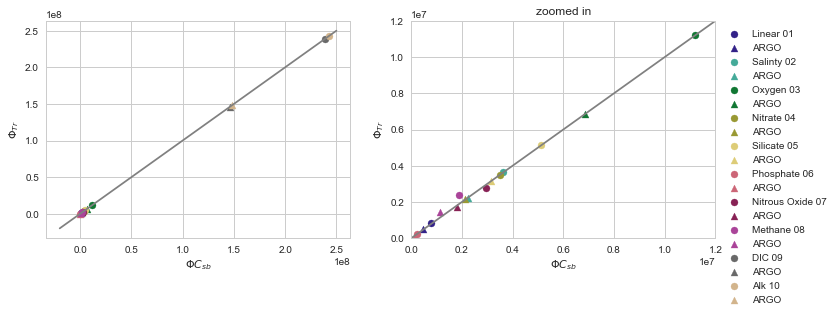

In [14]:
fig, (ax,ax2) = plt.subplots(1,2,figsize=(12,4))
xx = np.linspace(-0.2E8,2.5E8, 20)
ax.plot(xx,xx,'-', color='0.5')
ax2.plot(xx,xx,'-', color='0.5')

for key, col, lab, unit, C in zip(tracers, colours, labels, units, sb_conc_A):
    
    filename = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
    df = pd.read_csv(filename)
    TrMass = df['TrMassHCW'][:]
    HCW = df['HCW'][:]
    
    filenameARGO = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_03.csv' %key)
    dfARGO = pd.read_csv(filenameARGO)
    TrMassARGO = dfARGO['TrMassHCW'][:]
    HCWARGO = dfARGO['HCW'][:]
    
    Phi = np.mean(np.array([(HCW[ii]-HCW[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    Phi_std = np.std(np.array([(HCW[ii]-HCW[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr = np.mean(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_std = np.std(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    
    PhiARGO = np.mean(np.array([(HCWARGO[ii]-HCWARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    Phi_stdARGO = np.std(np.array([(HCWARGO[ii]-HCWARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTrARGO = np.mean(np.array([(TrMassARGO[ii]-TrMassARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_stdARGO = np.std(np.array([(TrMassARGO[ii]-TrMassARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    
    error = 100*(Phi*C-PhiTr)/PhiTr
    errorARGO = 100*(PhiARGO*C-PhiTrARGO)/PhiTrARGO
    
    ax.scatter(Phi*C, PhiTr, c=col, label=lab)
    ax2.scatter(Phi*C, PhiTr, c=col, label=lab)
     
    ax.scatter(PhiARGO*C, PhiTrARGO,marker='^', c=col, label=lab)
    ax2.scatter(PhiARGO*C, PhiTrARGO,marker='^', c=col, label='ARGO')
    
    print('%s, error %1.3f percent ' %(lab, error))
    print('%s ARGO, error %1.3f percent ' %(lab, errorARGO))
ax.set_ylabel(r'$\Phi_{Tr}$')
ax.set_xlabel(r'$\Phi C_{sb}$')
ax2.set_ylabel(r'$\Phi_{Tr}$')
ax2.set_xlabel(r'$\Phi C_{sb}$')
ax2.set_xlim(0,0.12E8)
ax2.set_ylim(0,0.12E8)
   
ax2.legend(bbox_to_anchor=(1,1))
ax2.set_title('zoomed in')
print(Phi)
print(PhiARGO)

It is reasonable to scale tracer flux $\Phi_{Tr}$ as upwelling flux $\Phi C_{sb}$ within 0.5% except for Linear (5%) and Methane ($\sim$22%) and nitrous oxide ($\sim$6%)

### 4. Upwelled tracer - Barkley bathymetries

**Canyon runs**

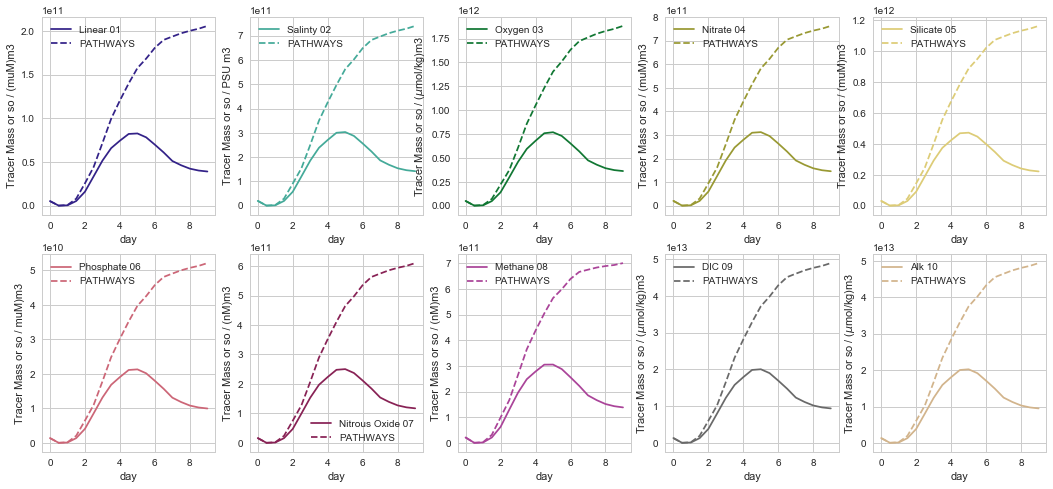

In [15]:
fig, ((ax0,ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8,ax9)) = plt.subplots(2,5,figsize=(18,8))

units = ['(muM)m3','PSU m3','($\mu$mol/kg)m3','(muM)m3','(muM)m3','muM)m3','(nM)m3',
         '(nM)m3','($\mu$mol/kg)m3','($\mu$mol/kg)m3']

axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for key, col, lab, unit,ax in zip(tracers, colours, labels, units, axes):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_01.csv' %key)
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_03.csv' %key)
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
    
    TrMass_Ast = df_Ast['TrMassHCW']
    TrMass_Argo = df_Argo['TrMassHCW']
    
    ax.plot(np.arange(19)/2, TrMass_Ast, color=col, label=lab)
    ax.plot(np.arange(19)/2, TrMass_Argo,'--', color=col, label='PATHWAYS')
    ax.legend()
    ax.set_ylabel(r'Tracer Mass or so / %s' %unit)
    ax.set_xlabel('day')


**Barkley shelf, no canyon**

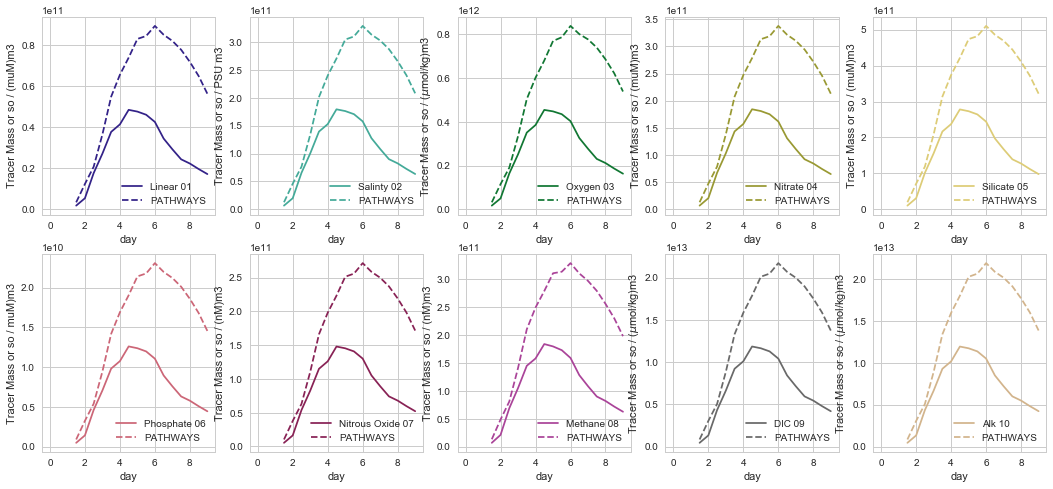

In [16]:
fig, ((ax0,ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8,ax9)) = plt.subplots(2,5,figsize=(18,8))

units = ['(muM)m3','PSU m3','($\mu$mol/kg)m3','(muM)m3','(muM)m3','muM)m3','(nM)m3',
         '(nM)m3','($\mu$mol/kg)m3','($\mu$mol/kg)m3']

axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for key, col, lab, unit,ax in zip(tracers, colours, labels, units, axes):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_02.csv' %key)
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_04.csv' %key)
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
    
    TrMass_Ast = df_Ast['TrMassHCW']
    TrMass_Argo = df_Argo['TrMassHCW']
    
    ax.plot(np.arange(19)/2, TrMass_Ast, color=col, label=lab)
    ax.plot(np.arange(19)/2, TrMass_Argo,'--', color=col, label='PATHWAYS')
    ax.legend()
    ax.set_ylabel(r'Tracer Mass or so / %s' %unit)
    ax.set_xlabel('day')


**Canyon effect** (Can - no Can)

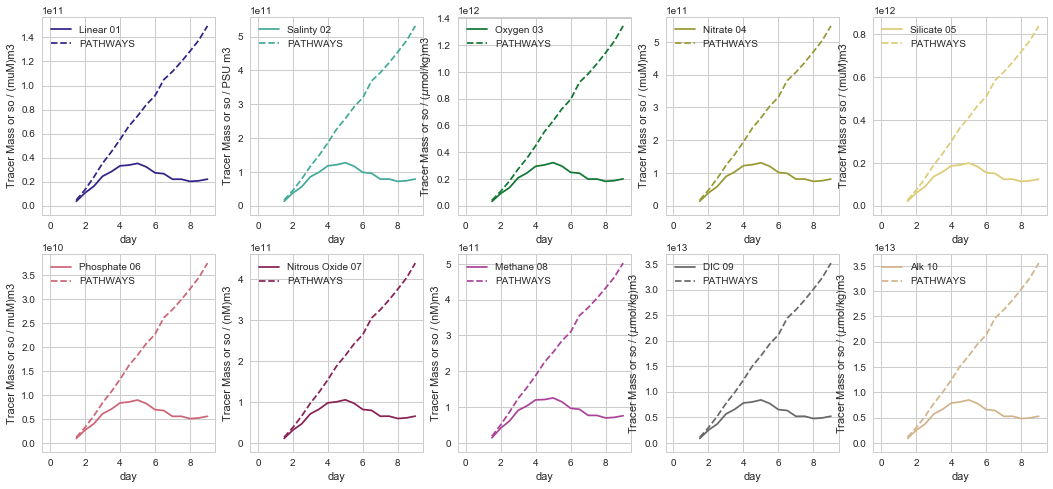

In [17]:
fig, ((ax0,ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8,ax9)) = plt.subplots(2,5,figsize=(18,8))

units = ['(muM)m3','PSU m3','($\mu$mol/kg)m3','(muM)m3','(muM)m3','muM)m3','(nM)m3',
         '(nM)m3','($\mu$mol/kg)m3','($\mu$mol/kg)m3']

axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for key, col, lab, unit,ax in zip(tracers, colours, labels, units, axes):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_01.csv' %key)
    f_AstNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_02.csv' %key)
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_03.csv' %key)
    f_ArgoNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_04.csv' %key)
    
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
    df_AstNoC = pd.read_csv(f_AstNoC)
    df_ArgoNoC = pd.read_csv(f_ArgoNoC)
    
    TrMass_Ast = df_Ast['TrMassHCW']
    TrMass_Argo = df_Argo['TrMassHCW']
    TrMass_AstNoC = df_AstNoC['TrMassHCW']
    TrMass_ArgoNoC = df_ArgoNoC['TrMassHCW']
    
    ax.plot(np.arange(19)/2, TrMass_Ast-TrMass_AstNoC, color=col, label=lab)
    ax.plot(np.arange(19)/2, TrMass_Argo-TrMass_ArgoNoC,'--', color=col, label='PATHWAYS')
    ax.legend()
    ax.set_ylabel(r'Tracer Mass or so / %s' %unit)
    ax.set_xlabel('day')



#### 4.1 Tracer flux vs upwelling flux $\times$ C_sb (all from model output)

Linear 01, error -23.572 percent 
Linear 01 PATH., error -21.803 percent 
Salinty 02, error -0.334 percent 
Salinty 02 PATH., error -0.016 percent 
Oxygen 03, error 27.332 percent 
Oxygen 03 PATH., error 17.001 percent 
Nitrate 04, error -7.950 percent 
Nitrate 04 PATH., error -5.753 percent 
Silicate 05, error -11.403 percent 
Silicate 05 PATH., error -9.507 percent 
Phosphate 06, error -7.369 percent 
Phosphate 06 PATH., error -5.188 percent 
Nitrous Oxide 07, error -1.718 percent 
Nitrous Oxide 07 PATH., error -0.643 percent 
Methane 08, error -54.794 percent 
Methane 08 PATH., error -40.448 percent 
DIC 09, error -1.416 percent 
DIC 09 PATH., error -0.742 percent 
Alk 10, error -0.506 percent 
Alk 10 PATH., error -0.209 percent 
-6288.967068212187
25848.25118546129


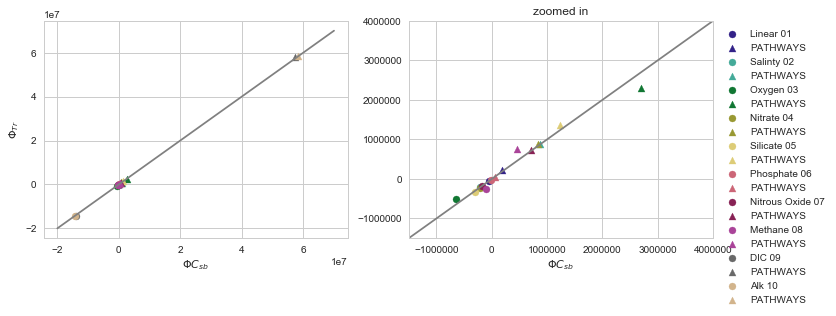

In [25]:
fig, (ax,ax2) = plt.subplots(1,2,figsize=(12,4))
xx = np.linspace(-0.2E8,0.7E8, 20)
ax.plot(xx,xx,'-', color='0.5')
ax2.plot(xx,xx,'-', color='0.5')

for key, col, lab, unit, C in zip(tracers, colours, labels, units, sb_conc_A):
    
    filename = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_01.csv' %key)
    df = pd.read_csv(filename)
    TrMass = df['TrMassHCW'][:]
    HCW = df['HCW'][:]
    
    filenameARGO = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_03.csv' %key)
    dfARGO = pd.read_csv(filenameARGO)
    TrMassARGO = dfARGO['TrMassHCW'][:]
    HCWARGO = dfARGO['HCW'][:]
    
    Phi = np.mean(np.array([(HCW[ii]-HCW[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    Phi_std = np.std(np.array([(HCW[ii]-HCW[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr = np.mean(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_std = np.std(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    
    PhiARGO = np.mean(np.array([(HCWARGO[ii]-HCWARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    Phi_stdARGO = np.std(np.array([(HCWARGO[ii]-HCWARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTrARGO = np.mean(np.array([(TrMassARGO[ii]-TrMassARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_stdARGO = np.std(np.array([(TrMassARGO[ii]-TrMassARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    
    error = 100*((Phi*C)-PhiTr)/PhiTr
    errorARGO = 100*((PhiARGO*C)-PhiTrARGO)/PhiTrARGO
    
    ax.scatter(Phi*C, PhiTr, c=col, label=lab)
    ax2.scatter(Phi*C, PhiTr, c=col, label=lab)
     
    ax.scatter(PhiARGO*C, PhiTrARGO,marker='^', c=col, label=lab)
    ax2.scatter(PhiARGO*C, PhiTrARGO,marker='^', c=col, label='PATHWAYS')
    
    print('%s, error %1.3f percent ' %(lab, error))
    print('%s PATH., error %1.3f percent ' %(lab, errorARGO))
ax.set_ylabel(r'$\Phi_{Tr}$')
ax.set_xlabel(r'$\Phi C_{sb}$')
ax2.set_xlabel(r'$\Phi C_{sb}$')
ax2.set_xlim(-0.015E8,0.04E8)
ax2.set_ylim(-0.015E8,0.04E8)
   
ax2.legend(bbox_to_anchor=(1,1))
ax2.set_title('zoomed in')
print(Phi)
print(PhiARGO)

Upwelled water flux is negative for Barkley... 

Errors are larger than for Astoria, considering only PATHWAYS: 22% linear, 17% oxygen, 6% nitrate, 40% methane, 10% silicate, 5% phosphate

### 5. Comparison to previous scalings

In [19]:
def Dh(f,L,N):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U,f,R):
    '''Rossby number'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N,f,W,Hs):
    '''Burger number'''
    return((N*Hs)/(f*W))

def RossbyRad(N,Hs,f):
    '''1st Rossby radius of deformation'''
    return((N*Hs)/f)

def SE(s,N,f,Fw,Rl):
    '''Slope effect '''
    return((s*N)/(f*(Fw/Rl)**0.5))

In [20]:
g = 9.81 # accel. gravity
Hs = 150 # Shelf break depth
s = 0.00230 # shelf slope 
N = 5.5E-3
f = 1.0E-4
U = 0.3
Wiso = 8900
L = 21800

#H&A 2013
slope = 0.91 
param = 1.21
intercept = 0.07

# From cell in 3.1
Phi_model = 107397.14556475678 # m^3/s

Se = SE(s, N, f, F(Ro(U,f,Wiso)), Ro(U,f,L))
HA2013=((slope*(F(Ro(U,f,Wiso))**(3/2))*(Ro(U,f,L)**(1/2))*((1-param*Se)**3))+intercept)*(U*Wiso*Dh(f,L,N))

print('Phi_HA2013 = %1.3e m^3/s, Phi_model=%1.3e m^3/s, error %1.2f percent' %(HA2013, Phi_model, 100*(HA2013-Phi_model)/Phi_model))

Phi_HA2013 = 1.101e+05 m^3/s, Phi_model=1.074e+05 m^3/s, error 2.47 percent


Linear 01, error -2.526 percent 
Salinty 02, error 2.650 percent 
Oxygen 03, error 2.060 percent 
Nitrate 04, error 2.053 percent 
Silicate 05, error 2.070 percent 
Phosphate 06, error 2.367 percent 
Nitrous Oxide 07, error 8.984 percent 
Methane 08, error -19.628 percent 
DIC 09, error 2.690 percent 
Alk 10, error 2.650 percent 
8291.545246966078


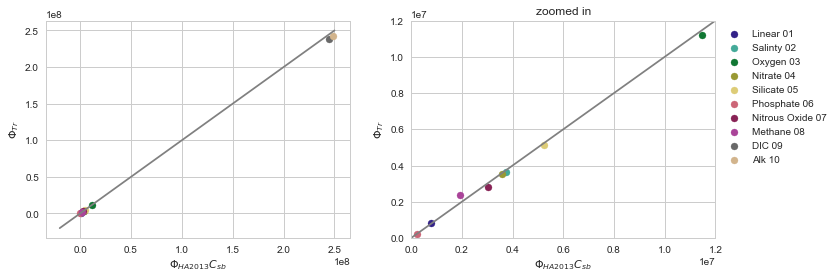

In [21]:
fig, (ax,ax2) = plt.subplots(1,2,figsize=(12,4))
xx = np.linspace(-0.2E8,2.5E8, 20)
ax.plot(xx,xx,'-', color='0.5')
ax2.plot(xx,xx,'-', color='0.5')

for key, col, lab, unit, C in zip(tracers, colours, labels, units, sb_conc_A):
    
    filename = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
    df = pd.read_csv(filename)
    TrMass = df['TrMassHCW'][:]
    PhiTr = np.mean(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_std = np.std(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    
    error = 100*(HA2013*C-PhiTr)/PhiTr
    
    ax.scatter(HA2013*C, PhiTr, c=col, label=lab)
    ax2.scatter(HA2013*C, PhiTr, c=col, label=lab)
     
    
    print('%s, error %1.3f percent ' %(lab, error))

ax.set_ylabel(r'$\Phi_{Tr}$')
ax.set_xlabel(r'$\Phi_{HA2013} C_{sb}$')
ax2.set_ylabel(r'$\Phi_{Tr}$')
ax2.set_xlabel(r'$\Phi_{HA2013} C_{sb}$')
ax2.set_xlim(0,0.12E8)
ax2.set_ylim(0,0.12E8)
   
ax2.legend(bbox_to_anchor=(1,1))
ax2.set_title('zoomed in')
print(Phi)

Still pretty good! Linear has smaller error and methane is the only bad one.

ARGO:

In [22]:
# ARGO RUN
g = 9.81 # accel. gravity
Hs = 150 # Shelf break depth
s = 0.00230 # shelf slope 
N = 0.00880 # Initial at 152.5 m
f = 1.05E-4
U = 0.3
Wiso = 8900
L = 21800

#H&A 2013
slope = 0.91 
param = 1.21
intercept = 0.07

# From cell in 3.1
Phi_model = 65720.85262122174 # m^3/s

Se = SE(s, N, f, F(Ro(U,f,Wiso)), Ro(U,f,L))
HA2013=((slope*(F(Ro(U,f,Wiso))**(3/2))*(Ro(U,f,L)**(1/2))*((1-param*Se)**3))+intercept)*(U*Wiso*Dh(f,L,N))

print('Phi_HA2013 = %1.3e m^3/s, Phi_model=%1.3e m^3/s, error %1.2f percent' %(HA2013, Phi_model, 100*(HA2013-Phi_model)/Phi_model))

Phi_HA2013 = 6.659e+04 m^3/s, Phi_model=6.572e+04 m^3/s, error 1.33 percent


**Barkley Runs**

In [23]:
g = 9.81 # accel. gravity
Hs = 200 # Shelf break depth
s = 0.00454 # shelf slope 
N = 5.5E-3
f = 1.0E-4
U = 0.3
Wiso = 8300.0
L = 6400

#H&A 2013
slope = 0.91 
param = 1.21
intercept = 0.07

# From cell in 3.1
Phi_model = -6288.967068212187 # m^3/s

Se = SE(s, N, f, F(Ro(U,f,Wiso)), Ro(U,f,L))
HA2013=((slope*(F(Ro(U,f,Wiso))**(3/2))*(Ro(U,f,L)**(1/2))*((1-param*Se)**3))+intercept)*(U*Wiso*Dh(f,L,N))

print('Phi_HA2013 = %1.3e m^3/s, Phi_model=%1.3e m^3/s, error %1.2f percent' %(HA2013, Phi_model, 100*(HA2013-Phi_model)/Phi_model))


Phi_HA2013 = 2.668e+04 m^3/s, Phi_model=-6.289e+03 m^3/s, error -524.19 percent


Wow, look at that error! No surprise since HCW decreases after day 5 in Barkley run.

PATHWAYS:

In [24]:
# Pahways
g = 9.81 # accel. gravity
Hs = 200 # Shelf break depth
s = 0.00454 # shelf slope 
N = 0.00469   #0.00399
f = 1.08E-4
U = 0.3
Wiso = 8300.0
L = 6400

#H&A 2013
slope = 0.91 
param = 1.21
intercept = 0.07

# From cell in 3.1
Phi_model = 25848.25118546129 # m^3/s

Se = SE(s, N, f, F(Ro(U,f,Wiso)), Ro(U,f,L))
HA2013=((slope*(F(Ro(U,f,Wiso))**(3/2))*(Ro(U,f,L)**(1/2))*((1-param*Se)**3))+intercept)*(U*Wiso*Dh(f,L,N))

print('Phi_HA2013 = %1.3e m^3/s, Phi_model=%1.3e m^3/s, error %1.2f percent' %(HA2013, Phi_model, 100*(HA2013-Phi_model)/Phi_model))


Phi_HA2013 = 3.625e+04 m^3/s, Phi_model=2.585e+04 m^3/s, error 40.25 percent


For Barkley runs, the error goes down if I consider a shorter time while HCW is increasing -- days 4-6 for PATHWAYS (17%) and 4-5 for BARKLEY (26%))